In [ ]:
!pip install yfinance

**Data Pre-processing and Compilation**

In [6]:
import pandas as pd
import yfinance as yf

In [ ]:
c1 = pd.read_csv("comp_exec.csv")
c2 = pd.read_csv("comp_ticker.csv")
c3 = pd.read_csv("exec_comp.csv")
c4 = pd.read_csv("exec_comp_10.csv")
c5 = pd.read_csv("key_dev.csv")

name_map = dict()
name_map["Alphabet Inc."] = "GOOGL"
name_map["Apple Inc."] = "AAPL"
name_map["Meta Platforms, Inc."] = "META"
name_map["Microsoft Corporation"] = "MSFT"
name_map["NVIDIA Corporation"] = "NVDA"
name_map["Tesla, Inc."] = "TSLA"
name_map["Walmart Inc."] = "WMT"
name_map["Eli Lilly and Company"] = "LLY"
name_map["J.P. Morgan Exchange-Traded Fund Trust - JPMorgan Social Advancement ETF"] = "JPM"

c5["TICKER"] = c5["companyname"].map(name_map)
c5 = c5.dropna()
c5 = c5.rename(columns={"year": "YEAR", "count": "ART_COUNT"})
c5 = c5[["TICKER", "YEAR", "ART_COUNT"]]
c3 = c3.merge(c5, on=["TICKER", "YEAR"])

ann_rep = pd.read_csv("ann_rep.csv")
ann_rep = ann_rep.rename(columns={"ticker": "TICKER", "year": "YEAR", "culture_emphasis": "CULT_EMPH"})
ann_rep["TICKER"] = ann_rep["TICKER"].str.upper()
ann_rep.head()

overall = c3.merge(ann_rep, on=["TICKER", "YEAR"])
overall.head(15)

,TICKER,YEAR,SALARY_SALARY_mean,SALARY_SALARY_std,BONUS_BONUS_mean,BONUS_BONUS_std,TDC1_TDC1_mean,TDC1_TDC1_std,SAL_PCT_SAL_PCT_mean,SAL_PCT_SAL_PCT_std,TDC1_PCT_TDC1_PCT_mean,TDC1_PCT_TDC1_PCT_std,PAGE_PAGE_mean,PAGE_PAGE_std,ISR_ISR_mean,ISR_ISR_std,TENURE_TENURE_mean,TENURE_TENURE_std,ART_COUNT,CULT_EMPH
0,AAPL,2014,952.513571,404.485785,71.428571,188.982237,24990.542833,25011.522627,12.509200,6.921078,459.704750,422.424171,60.285714,1.253566,0.088960,0.087315,5.714286,6.264032,249,3.0
1,AAPL,2015,1166.666667,408.248290,0.000000,0.000000,22747.671000,6114.346999,41.573200,58.368519,7.513500,59.640656,61.333333,2.160247,0.065441,0.063241,5.166667,6.431692,229,1.0
2,AAPL,2016,1333.333333,816.496581,0.000000,0.000000,20479.468667,5747.489496,8.333333,20.412415,-10.450667,2.370238,61.333333,2.160247,0.093666,0.122122,6.166667,6.431692,208,2.0
3,AAPL,2017,1358.974500,832.198218,0.000000,0.000000,22272.872833,4628.544314,1.923000,0.000000,13.990000,18.235228,61.166667,2.401388,0.074888,0.080112,6.166667,6.911343,321,11.0
4,AAPL,2018,1376.923000,908.702228,0.000000,0.000000,24395.021400,4871.177670,-1.887000,0.000000,13.893000,7.262434,60.400000,1.516575,0.067501,0.069233,6.600000,8.294577,138,1.0


In [7]:
def get_price_history(ticker, period="10y"):
  ins = yf.Ticker(ticker)
  hist = ins.history(period=period)
  return hist

all_px = list()

for i, sym in enumerate(['AAPL', 'GOOGL', 'LLY', 'META', 'MSFT', 'NVDA', 'TSLA', 'WMT', 'SPY']):
  try:
    _df = get_price_history(sym).reset_index()
    _df = _df[["Date", "Open", "High", "Low", "Close", "Volume", "Dividends", "Stock Splits"]]
    _df["Date"] = pd.to_datetime(_df["Date"], utc=True)
    _df["Date"] = _df["Date"].dt.strftime('%Y%m%d')
    _df["symbol"] = sym
    all_px.append(_df)
  except:
    print(f"Failure: {i}/500: {sym}")
    continue

dp = pd.concat(all_px, ignore_index=True)
dp["DATE"] = dp["Date"]
dp["RET"] = dp["Close"]
dp["TICKER"] = dp["symbol"]
dp["YEAR"] = dp["DATE"].apply(lambda x: str(x)[0:4])
dp = dp[["DATE", "RET", "TICKER", "YEAR"]]

dpn = list()
for t, tdf in dp.groupby("TICKER"):
  tdf = tdf.sort_values("DATE")
  tdf["RET"] = tdf["RET"].pct_change()
  dpn.append(tdf)

tdf = pd.concat(dpn, ignore_index=True).reset_index(drop=True)
tdf = tdf.reset_index(drop=True)
tdf = tdf[tdf["YEAR"] >= "2019"]
tdf = tdf[tdf["YEAR"] < "2024"]

cum_tdf = list()
for t, t_tdf in tdf.groupby("TICKER"):
  t_tdf = t_tdf.sort_values("DATE").reset_index(drop=True)
  t_tdf["RET"] = t_tdf["RET"] + 1
  t_tdf["RET"] = t_tdf["RET"].cumprod()
  t_tdf["RET"] = t_tdf["RET"] - 1
  cum_tdf.append(t_tdf)

cum_tdf = pd.concat(cum_tdf, ignore_index=True).reset_index(drop=True)
cum_tdf['DATE_DT'] = pd.to_datetime(cum_tdf['DATE'])

# Filter relevant data
tdf_sp = tdf[tdf["TICKER"] == "SPY"]
cum_tdf_sp = cum_tdf[cum_tdf["TICKER"] == "SPY"]

**Model Fitting and Backtesting**

MSE Linear regresssion: 0.1677756831721813
MSE random Forest: 0.22615622332687568
MSE XGBoost: 0.25394346559169967


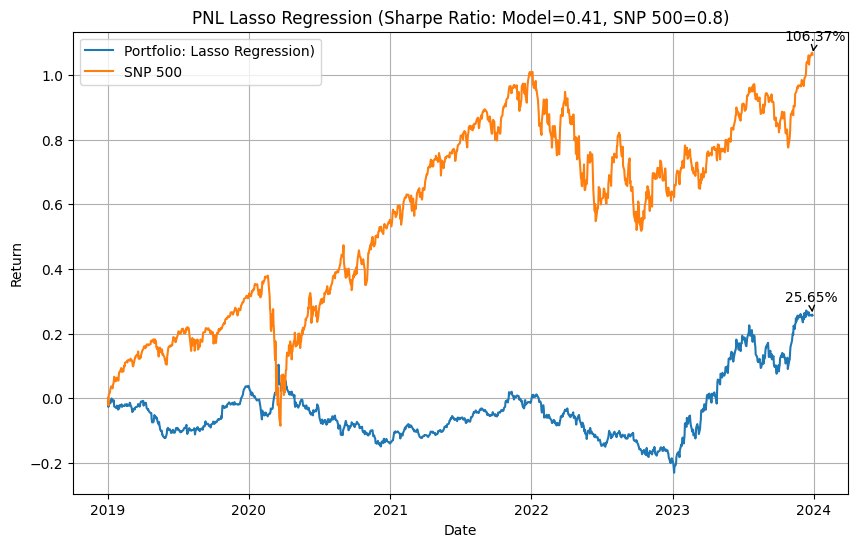

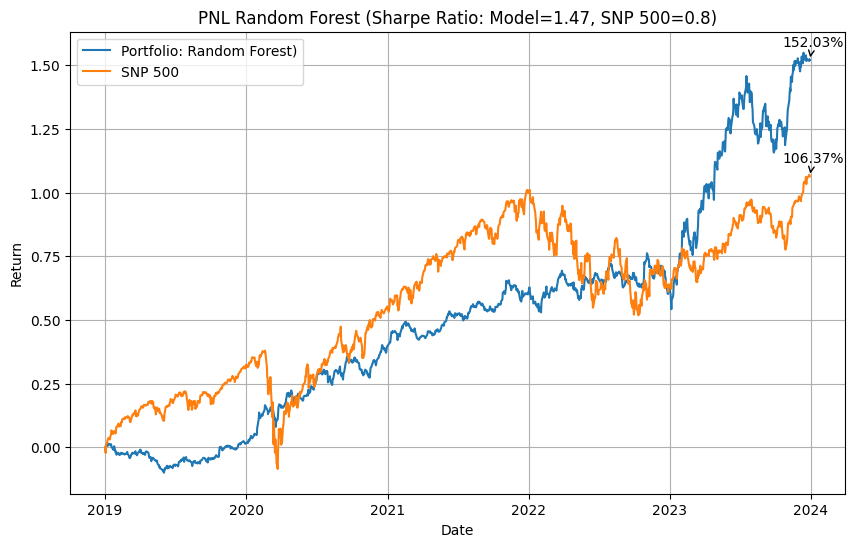

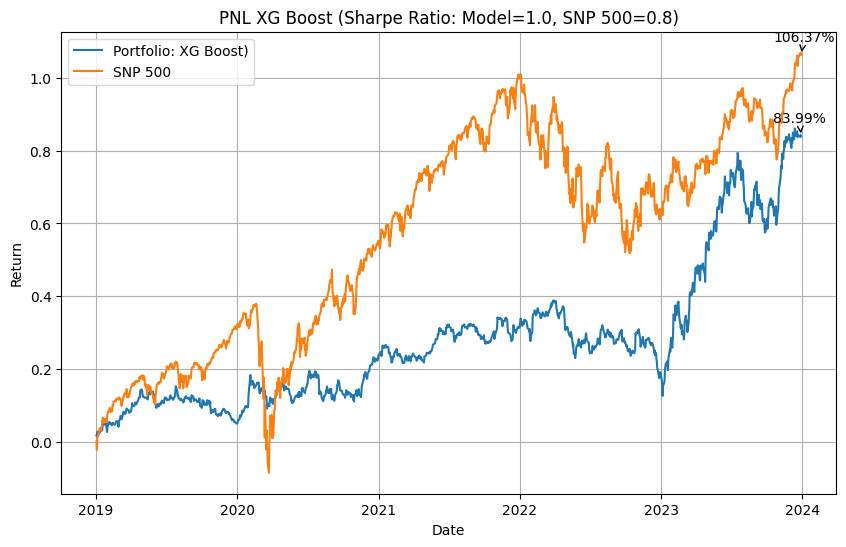

In [8]:
# Analysis starts here
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# =================
# Data Preparation
# =================
overall = pd.read_csv("overall.csv")
overall = overall.rename(columns={c: c.upper() for c in overall.columns.tolist()})

ann = pd.read_csv("ann_pnl.csv")
ann = ann.rename(columns={c: c.upper() for c in ann.columns.tolist()})

final = overall.merge(ann, on=["TICKER", "YEAR"])

# =========================================
# Split the data into train, test, predict
# =========================================
train = final[final["YEAR"] < 2019]
test = final[final["YEAR"] == 2019]
predict = final[final["YEAR"] >= 2019]

# =========================================
# Define features and target variable
# =========================================

features = ['TDC1_TDC1_MEAN',
            'ISR_ISR_MEAN',
            'TENURE_TENURE_MEAN',
            'ART_COUNT', 'CULT_EMPH']

tgt = 'P'

# ================
# Model Training
# ================
# Linear Regression (Lasso)
lr_model = Lasso(alpha=0.1)
lr_model.fit(train[features], train[tgt])

# Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(train[features], train[tgt])

# XGBoost
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(train[features], train[tgt])


def get_model_test_results(data):
    lr_predictions = lr_model.predict(data[features])
    lr_rmse = mean_squared_error(data[tgt], lr_predictions, squared=False)

    rf_predictions = rf_model.predict(data[features])
    rf_rmse = mean_squared_error(data[tgt], rf_predictions, squared=False)

    xgb_predictions = xgb_model.predict(data[features])
    xgb_rmse = mean_squared_error(data[tgt], xgb_predictions, squared=False)

    print(f"MSE Linear regresssion: {lr_rmse}")
    print(f"MSE random Forest: {rf_rmse}")
    print(f"MSE XGBoost: {xgb_rmse}")


def get_model_results(data):
    lr = lr_model.predict(data[features])
    rf = rf_model.predict(data[features])
    xgb = xgb_model.predict(data[features])
    return lr, rf, xgb

get_model_test_results(test)

# Generate predictions
lr, rf, xgb = get_model_results(predict)
pred = predict[["TICKER", "YEAR"]].copy()
pred["LR"] = lr
pred["RF"] = rf
pred["XGB"] = xgb

models = ["LR", "RF", "XGB"]
rank_df = list()
pred = pred.dropna()

# Generate ranks based on prediction
for yr, yr_df in pred.groupby("YEAR"):
  for m in models:
    _sorted = yr_df.sort_values(m, ascending=False).reset_index()
    _rdf = pd.DataFrame()
    _rdf["TICKER"] = _sorted["TICKER"].tolist()
    _rdf["YEAR"] = yr
    _rdf["EXP"] = _sorted[m]
    _rdf["MODEL"] = m
    _rdf["RANK"] = [i + 1 for i in range(len(_rdf))]
    _rdf["POS"] = _rdf["RANK"].map({1: 1, 2: 1, 3: 1, 4: 1,
                                    5: -1, 6: -1, 7: -1, 8: -1})
    _rdf["POS"] = _rdf["POS"]/_rdf["POS"].abs().sum()
    rank_df.append(_rdf)

rank_df = pd.concat(rank_df, ignore_index=True).reset_index(drop=True)
rank_df["YEAR"] = rank_df["YEAR"].astype(int)
tdf["YEAR"] = tdf["YEAR"].astype(int)

fin = tdf.merge(rank_df[["TICKER", "YEAR", "POS", "MODEL"]].drop_duplicates(keep="first"),
                on=["TICKER", "YEAR"],
                how="left")

fin = fin[fin["YEAR"] >= 2019]
fin = fin[fin["YEAR"] < 2024]

fin_lr = fin[fin["MODEL"] == "LR"].copy()
fin_rf = fin[fin["MODEL"] == "RF"].copy()
fin_xgb = fin[fin["MODEL"] == "XGB"].copy()

def calculate_returns_and_plot(f, model):
    f["RET"] = f["RET"] * f["POS"]
    f = f.groupby(["DATE"]).agg({"RET": "sum"}).reset_index()
    f = f.sort_values("DATE").reset_index(drop=True)

    sharpe_ratio = np.sqrt(252) * f["RET"].mean() / f["RET"].std()
    snp_sharpe_ratio = np.sqrt(252) * tdf_sp["RET"].mean() / tdf_sp["RET"].std()

    f["RET"] = f["RET"] + 1
    f["RET"] = f["RET"].cumprod()
    f["RET"] = f["RET"] - 1
    f['DATE'] = pd.to_datetime(f['DATE'])

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(f['DATE'], f['RET'], linestyle='-', label=f"Portfolio: {model})")
    plt.plot(pd.to_datetime(cum_tdf_sp['DATE']), cum_tdf_sp['RET'], label="SNP 500")

    # Add annotation for the final value
    plt.annotate(f'{f["RET"].iloc[-1]:.2%}', xy=(f['DATE'].iloc[-1], f['RET'].iloc[-1]),
                 xytext=(-20, 10), textcoords='offset points', fontsize=10,
                 arrowprops=dict(arrowstyle='->', color='black'))

    plt.annotate(f'{cum_tdf_sp["RET"].iloc[-1]:.2%}',
                 xy=(pd.to_datetime(cum_tdf_sp['DATE']).iloc[-1],
                     cum_tdf_sp['RET'].iloc[-1]),
                 xytext=(-20, 10), textcoords='offset points', fontsize=10,
                 arrowprops=dict(arrowstyle='->', color='black'))

    plt.title(f'PNL {model} (Sharpe Ratio: Model={round(sharpe_ratio, 2)}, SNP 500={round(snp_sharpe_ratio, 2)})')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.grid(True)
    plt.legend()
    plt.show()

    return f

fin_lr = calculate_returns_and_plot(fin_lr, "Lasso Regression")
fin_rf = calculate_returns_and_plot(fin_rf, "Random Forest")
fin_xgb = calculate_returns_and_plot(fin_xgb, "XG Boost")

MSE Linear regresssion: 0.16320381632337844
MSE random Forest: 0.1990622239731414
MSE XGBoost: 0.2212538859468483


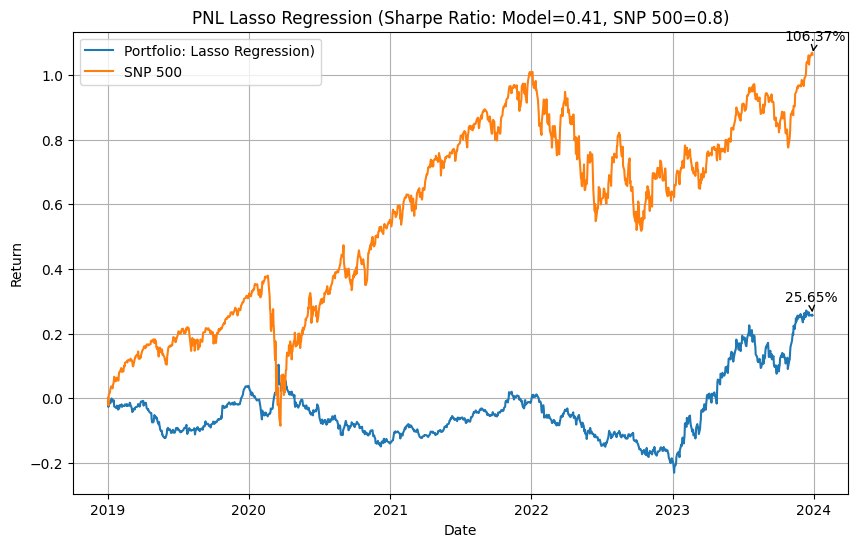

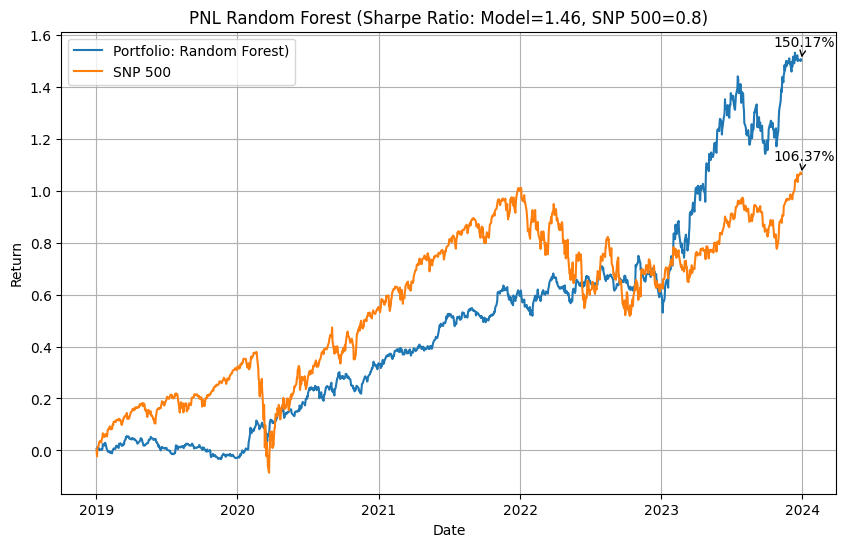

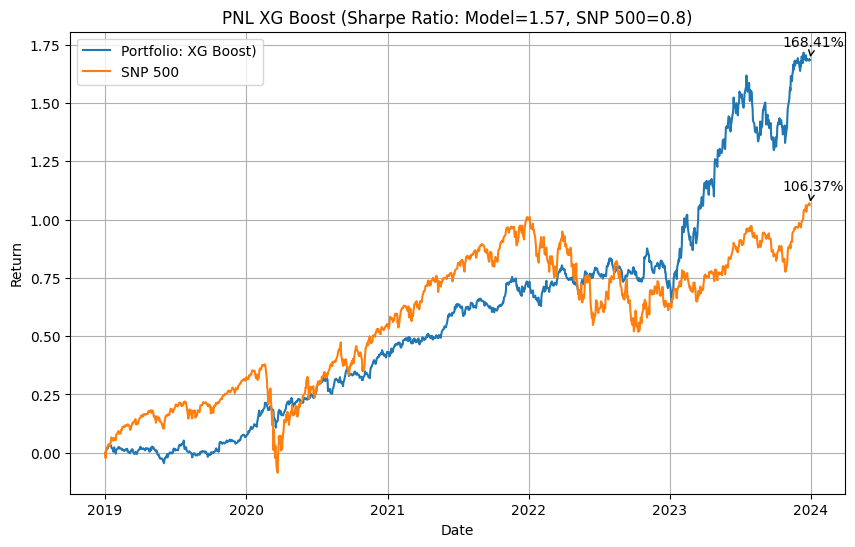

In [9]:
# Analysis starts here
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# =================
# Data Preparation
# =================
overall = pd.read_csv("overall.csv")
overall = overall.rename(columns={c: c.upper() for c in overall.columns.tolist()})

ann = pd.read_csv("ann_pnl.csv")
ann = ann.rename(columns={c: c.upper() for c in ann.columns.tolist()})

final = overall.merge(ann, on=["TICKER", "YEAR"])
final["P"] = final["P"] - final["H"]
final["PH"] = final["P"] - final["H"]

# =========================================
# Split the data into train, test, predict
# =========================================
train = final[final["YEAR"] < 2019]
test = final[final["YEAR"] == 2019]
predict = final[final["YEAR"] >= 2019]

# =========================================
# Define features and target variable
# =========================================

features = ['TDC1_TDC1_MEAN',
            'ISR_ISR_MEAN',
            'TENURE_TENURE_MEAN',
            'ART_COUNT', 'CULT_EMPH']

tgt = "PH"

# ================
# Model Training
# ================
# Linear Regression (Lasso)
lr_model = Lasso(alpha=0.1)
lr_model.fit(train[features], train[tgt])

# Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(train[features], train[tgt])

# XGBoost
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(train[features], train[tgt])


def get_model_test_results(data):
    lr_predictions = lr_model.predict(data[features])
    lr_rmse = mean_squared_error(data[tgt], lr_predictions, squared=False)

    rf_predictions = rf_model.predict(data[features])
    rf_rmse = mean_squared_error(data[tgt], rf_predictions, squared=False)

    xgb_predictions = xgb_model.predict(data[features])
    xgb_rmse = mean_squared_error(data[tgt], xgb_predictions, squared=False)

    print(f"MSE Linear regresssion: {lr_rmse}")
    print(f"MSE random Forest: {rf_rmse}")
    print(f"MSE XGBoost: {xgb_rmse}")


def get_model_results(data):
    lr = lr_model.predict(data[features])
    rf = rf_model.predict(data[features])
    xgb = xgb_model.predict(data[features])
    return lr, rf, xgb

get_model_test_results(test)

# Generate predictions
lr, rf, xgb = get_model_results(predict)
pred = predict[["TICKER", "YEAR"]].copy()
pred["LR"] = lr
pred["RF"] = rf
pred["XGB"] = xgb

models = ["LR", "RF", "XGB"]
rank_df = list()
pred = pred.dropna()

# Generate ranks based on prediction
for yr, yr_df in pred.groupby("YEAR"):
  for m in models:
    _sorted = yr_df.sort_values(m, ascending=False).reset_index()
    _rdf = pd.DataFrame()
    _rdf["TICKER"] = _sorted["TICKER"].tolist()
    _rdf["YEAR"] = yr
    _rdf["EXP"] = _sorted[m]
    _rdf["MODEL"] = m
    _rdf["RANK"] = [i + 1 for i in range(len(_rdf))]
    _rdf["POS"] = _rdf["RANK"].map({1: 1, 2: 1, 3: 1, 4: 1,
                                    5: -1, 6: -1, 7: -1, 8: -1})
    _rdf["POS"] = _rdf["POS"]/_rdf["POS"].abs().sum()
    rank_df.append(_rdf)

rank_df = pd.concat(rank_df, ignore_index=True).reset_index(drop=True)
rank_df["YEAR"] = rank_df["YEAR"].astype(int)
tdf["YEAR"] = tdf["YEAR"].astype(int)

fin = tdf.merge(rank_df[["TICKER", "YEAR", "POS", "MODEL"]].drop_duplicates(keep="first"),
                on=["TICKER", "YEAR"],
                how="left")

fin = fin[fin["YEAR"] >= 2019]
fin = fin[fin["YEAR"] < 2024]

fin_lr = fin[fin["MODEL"] == "LR"].copy()
fin_rf = fin[fin["MODEL"] == "RF"].copy()
fin_xgb = fin[fin["MODEL"] == "XGB"].copy()

def calculate_returns_and_plot(f, model):
    f["RET"] = f["RET"] * f["POS"]
    f = f.groupby(["DATE"]).agg({"RET": "sum"}).reset_index()
    f = f.sort_values("DATE").reset_index(drop=True)

    sharpe_ratio = np.sqrt(252) * f["RET"].mean() / f["RET"].std()
    snp_sharpe_ratio = np.sqrt(252) * tdf_sp["RET"].mean() / tdf_sp["RET"].std()

    f["RET"] = f["RET"] + 1
    f["RET"] = f["RET"].cumprod()
    f["RET"] = f["RET"] - 1
    f['DATE'] = pd.to_datetime(f['DATE'])

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(f['DATE'], f['RET'], linestyle='-', label=f"Portfolio: {model})")
    plt.plot(pd.to_datetime(cum_tdf_sp['DATE']), cum_tdf_sp['RET'], label="SNP 500")

    # Add annotation for the final value
    plt.annotate(f'{f["RET"].iloc[-1]:.2%}', xy=(f['DATE'].iloc[-1], f['RET'].iloc[-1]),
                 xytext=(-20, 10), textcoords='offset points', fontsize=10,
                 arrowprops=dict(arrowstyle='->', color='black'))

    plt.annotate(f'{cum_tdf_sp["RET"].iloc[-1]:.2%}',
                 xy=(pd.to_datetime(cum_tdf_sp['DATE']).iloc[-1],
                     cum_tdf_sp['RET'].iloc[-1]),
                 xytext=(-20, 10), textcoords='offset points', fontsize=10,
                 arrowprops=dict(arrowstyle='->', color='black'))

    plt.title(f'PNL {model} (Sharpe Ratio: Model={round(sharpe_ratio, 2)}, SNP 500={round(snp_sharpe_ratio, 2)})')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.grid(True)
    plt.legend()
    plt.show()

    return f

fin_lr = calculate_returns_and_plot(fin_lr, "Lasso Regression")
fin_rf = calculate_returns_and_plot(fin_rf, "Random Forest")
fin_xgb = calculate_returns_and_plot(fin_xgb, "XG Boost")

In [ ]:
rank_df.head()

,TICKER,YEAR,EXP,MODEL,RANK,POS
0,NVDA,2019,0.283107,LR,1,0.125
1,TSLA,2019,0.184506,LR,2,0.125
2,LLY,2019,0.147378,LR,3,0.125
3,AAPL,2019,0.147134,LR,4,0.125
4,META,2019,0.129708,LR,5,-0.125
